In [163]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 6)


# Data loading and initial preprocessing

In [164]:
# Load the data
df = pd.read_csv('input_data/Multi-Year Price Data (Aggregate).csv')

# Convert date and sort
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

print("Original Data:")
print(f"Shape: {df.shape}")
print(f"Date Range: {df['Date'].min()} to {df['Date'].max()}")
print(f"\nFirst 5 rows:")
print(df.head())
print(f"\nLast 5 rows:")
print(df.tail()) 

Original Data:
Shape: (1476, 2)
Date Range: 2012-01-01 00:00:00 to 2016-01-16 00:00:00

First 5 rows:
        Date  Price
0 2012-01-01     99
1 2012-01-02     95
2 2012-01-03     96
3 2012-01-04     95
4 2012-01-05     93

Last 5 rows:
           Date  Price
1471 2016-01-12    147
1472 2016-01-13    150
1473 2016-01-14    148
1474 2016-01-15    149
1475 2016-01-16    147


In [136]:
# Handle missing date (2012-07-13 was missing from EDA)
# Create complete date range
date_range = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')
df_complete = pd.DataFrame({'Date': date_range})

# Merge with original data
df_complete = df_complete.merge(df, on='Date', how='left')

# Fill missing price with interpolation (linear)
df_complete['Price'] = df_complete['Price'].interpolate(method='linear')

print("After handling missing dates:")
print(f"Shape: {df_complete.shape}")
print(f"Missing values: {df_complete.isnull().sum().sum()}")
print(f"\nMissing date filled (2012-07-13):")
print(df_complete[df_complete['Date'] == '2012-07-13'])

After handling missing dates:
Shape: (1477, 2)
Missing values: 0

Missing date filled (2012-07-13):
          Date  Price
194 2012-07-13   94.5


In [165]:
# Use the complete dataframe
df = df_complete.copy()

print(f"\nFinal Training Data:")
print(f"Shape: {df.shape}")
print(f"Date Range: {df['Date'].min()} to {df['Date'].max()}")
print(f"Total Days: {len(df)}")


Final Training Data:
Shape: (1477, 2)
Date Range: 2012-01-01 00:00:00 to 2016-01-16 00:00:00
Total Days: 1477


# Temporal feature creation

In [ ]:
# Basic temporal features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek  # Monday=0, Sunday=6
df['DayOfYear'] = df['Date'].dt.dayofyear
df['Week'] = df['Date'].dt.isocalendar().week
df['Quarter'] = df['Date'].dt.quarter

# Binary features
df['IsWeekend'] = (df['DayOfWeek'] >= 5).astype(int)
df['IsMonthStart'] = df['Date'].dt.is_month_start.astype(int)
df['IsMonthEnd'] = df['Date'].dt.is_month_end.astype(int)

# Special flag for February (our target month)
df['IsFebruary'] = (df['Month'] == 2).astype(int)

# Days since start (trend proxy)
df['DaysSinceStart'] = (df['Date'] - df['Date'].min()).dt.days

print("Temporal Features Created:")
print("="*80)
print(df[['Date', 'Price', 'Year', 'Month', 'DayOfWeek', 'DayOfYear', 
          'Quarter', 'IsWeekend', 'IsFebruary', 'DaysSinceStart']].head(10))

Temporal Features Created:
        Date  Price  Year  Month  DayOfWeek  DayOfYear  Quarter  IsWeekend  \
0 2012-01-01   99.0  2012      1          6          1        1          1   
1 2012-01-02   95.0  2012      1          0          2        1          0   
2 2012-01-03   96.0  2012      1          1          3        1          0   
3 2012-01-04   95.0  2012      1          2          4        1          0   
4 2012-01-05   93.0  2012      1          3          5        1          0   
5 2012-01-06   93.0  2012      1          4          6        1          0   
6 2012-01-07   95.0  2012      1          5          7        1          1   
7 2012-01-08   96.0  2012      1          6          8        1          1   
8 2012-01-09   98.0  2012      1          0          9        1          0   
9 2012-01-10   98.0  2012      1          1         10        1          0   

   IsFebruary  DaysSinceStart  
0           0               0  
1           0               1  
2           0     

# Cyclical Feature Encoding

In [ ]:
# Day of Year cyclical encoding (365 days in a year)
df['DayOfYear_Sin'] = np.sin(2 * np.pi * df['DayOfYear'] / 365)
df['DayOfYear_Cos'] = np.cos(2 * np.pi * df['DayOfYear'] / 365)

# Day of Week cyclical encoding (7 days in a week)
df['DayOfWeek_Sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
df['DayOfWeek_Cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)

print("Cyclical Features Created:")
print("="*80)
print(df[['Date', 'Month', 'DayOfWeek_Sin', 'DayOfWeek_Cos', 
          'DayOfYear', 'DayOfYear_Sin', 'DayOfYear_Cos']].head(10))


Cyclical Features Created:
        Date  Month  DayOfWeek_Sin  DayOfWeek_Cos  DayOfYear  DayOfYear_Sin  \
0 2012-01-01      1      -0.781831       0.623490          1       0.017213   
1 2012-01-02      1       0.000000       1.000000          2       0.034422   
2 2012-01-03      1       0.781831       0.623490          3       0.051620   
3 2012-01-04      1       0.974928      -0.222521          4       0.068802   
4 2012-01-05      1       0.433884      -0.900969          5       0.085965   
5 2012-01-06      1      -0.433884      -0.900969          6       0.103102   
6 2012-01-07      1      -0.974928      -0.222521          7       0.120208   
7 2012-01-08      1      -0.781831       0.623490          8       0.137279   
8 2012-01-09      1       0.000000       1.000000          9       0.154309   
9 2012-01-10      1       0.781831       0.623490         10       0.171293   

   DayOfYear_Cos  
0       0.999852  
1       0.999407  
2       0.998667  
3       0.997630  
4       

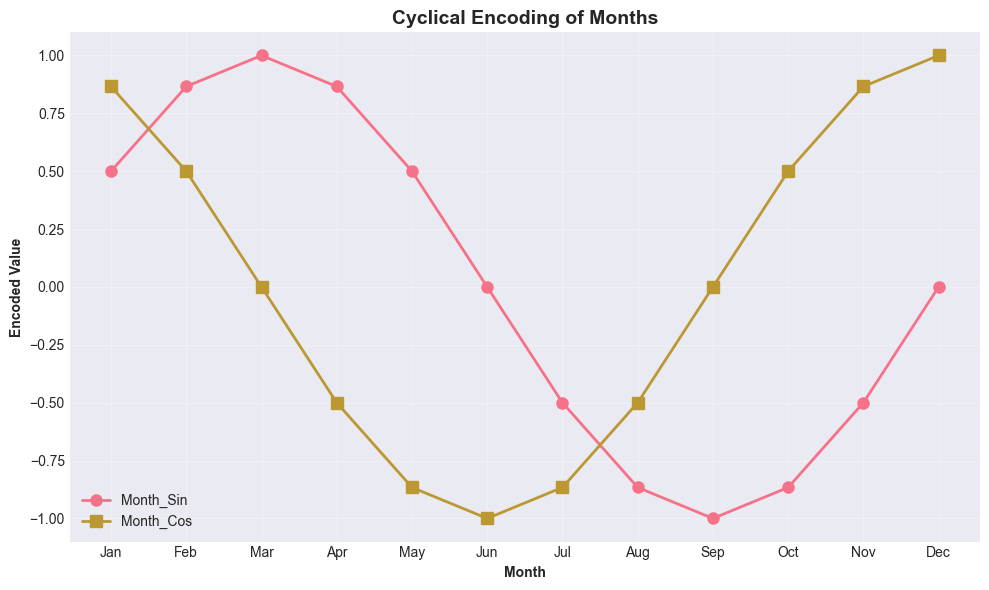


Note: December (12) and January (1) are now close in the encoded space!


In [ ]:
# Visualize cyclical encoding for Month
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
months = np.arange(1, 13)
month_sin = np.sin(2 * np.pi * months / 12)
month_cos = np.cos(2 * np.pi * months / 12)

ax.plot(months, month_sin, 'o-', label='Month_Sin', linewidth=2, markersize=8)
ax.plot(months, month_cos, 's-', label='Month_Cos', linewidth=2, markersize=8)
ax.set_xlabel('Month', fontweight='bold')
ax.set_ylabel('Encoded Value', fontweight='bold')
ax.set_title('Cyclical Encoding of Months', fontweight='bold', fontsize=14)
ax.set_xticks(months)
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

print("\nNote: December (12) and January (1) are now close in the encoded space!")

In [ ]:
df.head() 

,Date,Price,Year,Month,Day,DayOfWeek,DayOfYear,Week,Quarter,IsWeekend,IsMonthStart,IsMonthEnd,IsFebruary,DaysSinceStart,DayOfYear_Sin,DayOfYear_Cos,DayOfWeek_Sin,DayOfWeek_Cos
0,2012-01-01,99.0,2012,1,1,6,1,52,1,1,1,0,0,0,0.017213,0.999852,-0.781831,0.623490
1,2012-01-02,95.0,2012,1,2,0,2,1,1,0,0,0,0,1,0.034422,0.999407,0.000000,1.000000
2,2012-01-03,96.0,2012,1,3,1,3,1,1,0,0,0,0,2,0.051620,0.998667,0.781831,0.623490
3,2012-01-04,95.0,2012,1,4,2,4,1,1,0,0,0,0,3,0.068802,0.997630,0.974928,-0.222521
4,2012-01-05,93.0,2012,1,5,3,5,1,1,0,0,0,0,4,0.085965,0.996298,0.433884,-0.900969


# Feature selection and summary

In [179]:
# List all features created
all_features = [col for col in df.columns if col not in ['Date', 'Price']]

print(f"Total Features Created: {len(all_features)}")
print("="*80)
print("\nAll Features:")
for i, feat in enumerate(all_features, 1):
    print(f"{i:2d}. {feat}")

Total Features Created: 16

All Features:
 1. Year
 2. Month
 3. Day
 4. DayOfWeek
 5. DayOfYear
 6. Week
 7. Quarter
 8. IsWeekend
 9. IsMonthStart
10. IsMonthEnd
11. IsFebruary
12. DaysSinceStart
13. DayOfYear_Sin
14. DayOfYear_Cos
15. DayOfWeek_Sin
16. DayOfWeek_Cos


In [ ]:
# Check for missing values in features
df.isnull().sum()

Date              0
Price             0
Year              0
Month             0
Day               0
DayOfWeek         0
DayOfYear         0
Week              0
Quarter           0
IsWeekend         0
IsMonthStart      0
IsMonthEnd        0
IsFebruary        0
DaysSinceStart    0
DayOfYear_Sin     0
DayOfYear_Cos     0
DayOfWeek_Sin     0
DayOfWeek_Cos     0
dtype: int64

In [182]:
# Calculate correlations with Price (target variable)
# Use only rows without NaN for fair comparison
df_clean = df.dropna()

correlations = df_clean[all_features + ['Price']].corr()['Price'].sort_values(ascending=False)
correlations = correlations.drop('Price')  # Remove self-correlation

print("Top 20 Features Correlated with Price:")
print("="*80)
print(correlations.head(20))

print("\n" + "="*80)
print("Bottom 10 Features (Least/Negatively Correlated):")
print("="*80)
print(correlations.tail(10))

Top 20 Features Correlated with Price:
Year              0.621059
DayOfYear_Sin     0.525691
DaysSinceStart    0.492524
IsFebruary        0.219429
DayOfYear_Cos     0.097187
IsMonthStart      0.007497
DayOfWeek         0.001827
DayOfWeek_Sin    -0.001907
IsMonthEnd       -0.004906
Day              -0.015638
IsWeekend        -0.016605
DayOfWeek_Cos    -0.037290
Week             -0.443840
Month            -0.459865
DayOfYear        -0.460976
Quarter          -0.490190
Name: Price, dtype: float64

Bottom 10 Features (Least/Negatively Correlated):
DayOfWeek        0.001827
DayOfWeek_Sin   -0.001907
IsMonthEnd      -0.004906
Day             -0.015638
IsWeekend       -0.016605
DayOfWeek_Cos   -0.037290
Week            -0.443840
Month           -0.459865
DayOfYear       -0.460976
Quarter         -0.490190
Name: Price, dtype: float64


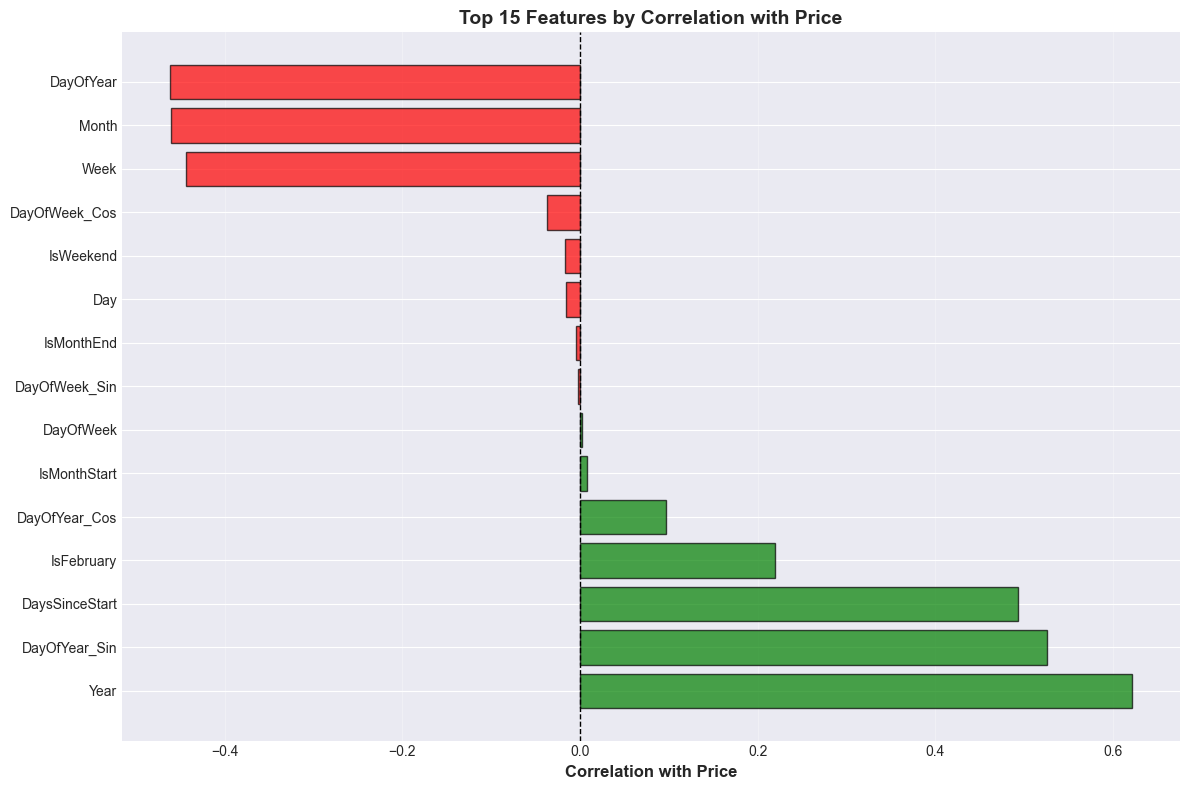

In [183]:
# Visualize top correlations
top_features = correlations.head(15).index.tolist()
corr_values = correlations.head(15).values

plt.figure(figsize=(12, 8))
colors = ['green' if x > 0 else 'red' for x in corr_values]
plt.barh(range(len(top_features)), corr_values, color=colors, alpha=0.7, edgecolor='black')
plt.yticks(range(len(top_features)), top_features)
plt.xlabel('Correlation with Price', fontweight='bold', fontsize=12)
plt.title('Top 15 Features by Correlation with Price', fontweight='bold', fontsize=14)
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()

plt.show()

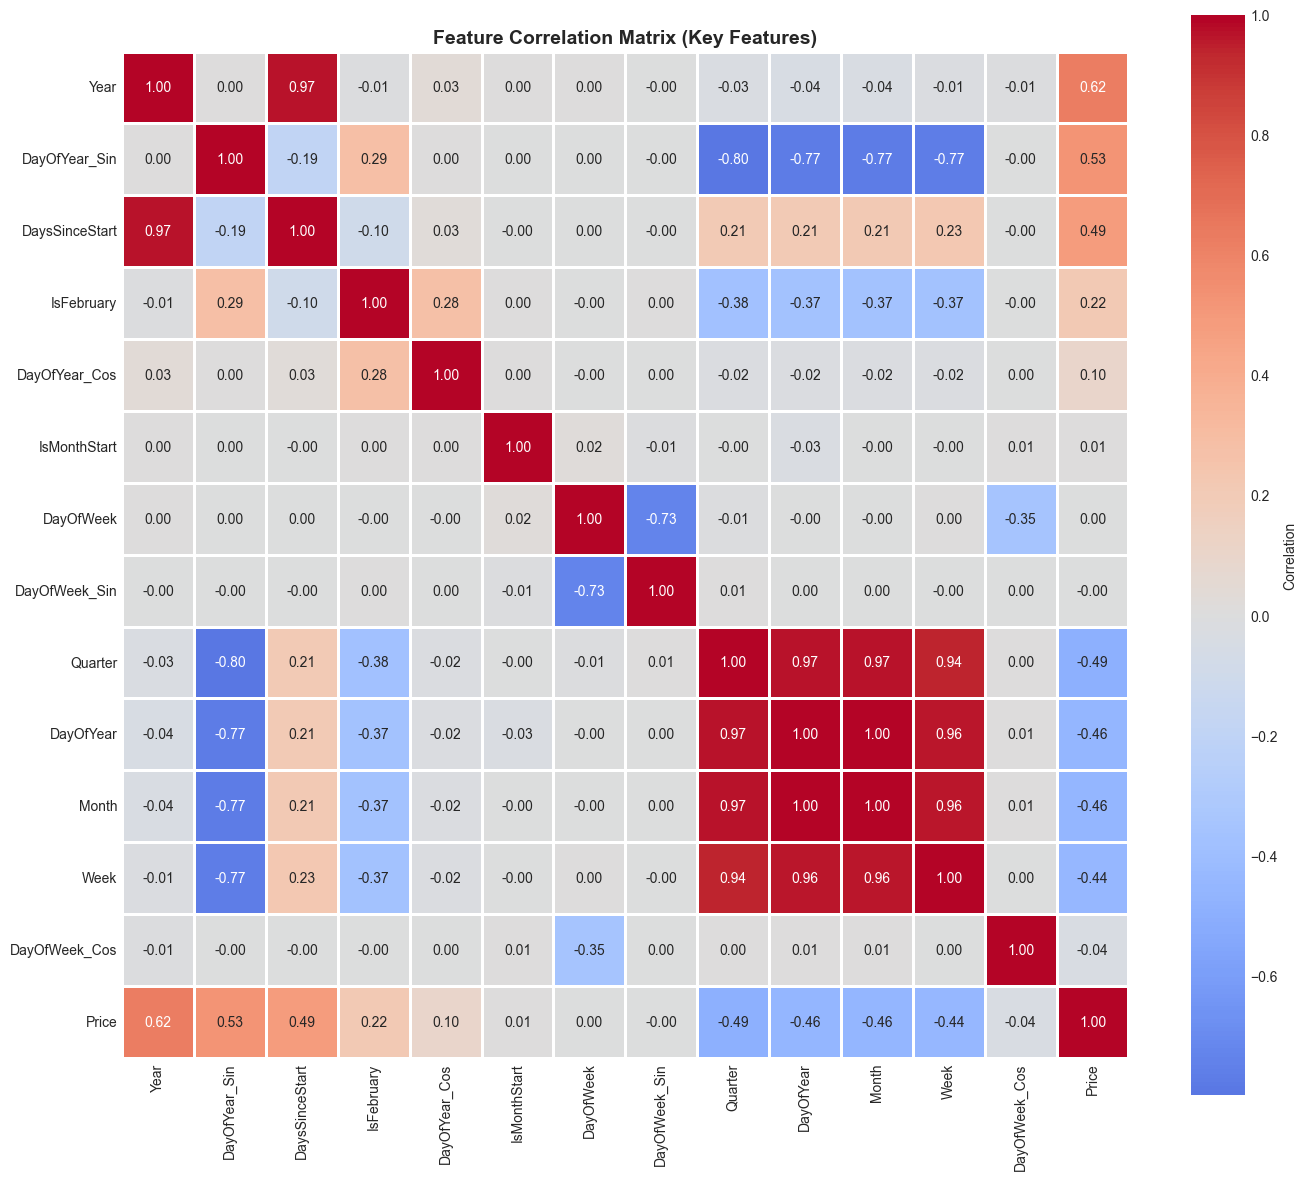


Insights:
- High correlation between a feature and Price → Important predictor
- High correlation between features → Potential multicollinearity (OK for tree models)


In [185]:
# Feature correlation heatmap (subset of important features)
important_features = ['Year', 'DayOfYear_Sin','DaysSinceStart','IsFebruary','DayOfYear_Cos','IsMonthStart','DayOfWeek','DayOfWeek_Sin',
'Quarter','DayOfYear','Month','Week','DayOfWeek_Cos', 'Price']

# Filter to available features
available_important = [f for f in important_features if f in df_clean.columns]

plt.figure(figsize=(14, 12))
corr_matrix = df_clean[available_important].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={'label': 'Correlation'})
plt.title('Feature Correlation Matrix (Key Features)', fontweight='bold', fontsize=14)
plt.tight_layout()

plt.show()

print("\nInsights:")
print("- High correlation between a feature and Price → Important predictor")
print("- High correlation between features → Potential multicollinearity (OK for tree models)")

# Train/validation split

In [187]:
# Define split date
split_date = '2015-07-01'

# Create train and validation sets
train_df = df[df['Date'] < split_date].copy()
val_df = df[df['Date'] >= split_date].copy()

print("TRAIN/VALIDATION SPLIT")
print("="*80)
print(f"\nTraining Set:")
print(f"  Date Range: {train_df['Date'].min()} to {train_df['Date'].max()}")
print(f"  Total Days: {len(train_df)}")
print(f"  Price Range: ${train_df['Price'].min():.2f} - ${train_df['Price'].max():.2f}")
print(f"  Mean Price: ${train_df['Price'].mean():.2f}")

print(f"\nValidation Set:")
print(f"  Date Range: {val_df['Date'].min()} to {val_df['Date'].max()}")
print(f"  Total Days: {len(val_df)}")
print(f"  Price Range: ${val_df['Price'].min():.2f} - ${val_df['Price'].max():.2f}")
print(f"  Mean Price: ${val_df['Price'].mean():.2f}")

TRAIN/VALIDATION SPLIT

Training Set:
  Date Range: 2012-01-01 00:00:00 to 2015-06-30 00:00:00
  Total Days: 1277
  Price Range: $81.00 - $281.00
  Mean Price: $112.86

Validation Set:
  Date Range: 2015-07-01 00:00:00 to 2016-01-16 00:00:00
  Total Days: 200
  Price Range: $101.00 - $157.00
  Mean Price: $121.97


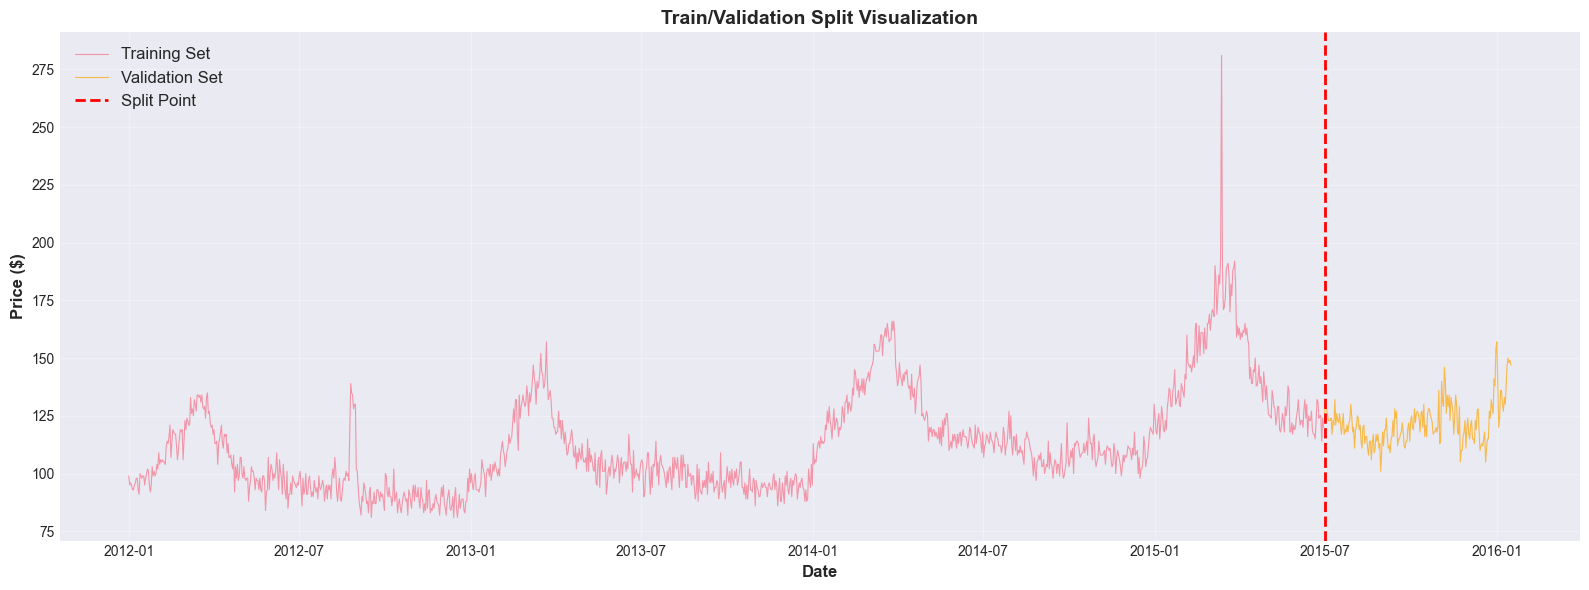

In [188]:
# Visualize the split
plt.figure(figsize=(16, 6)) 
plt.plot(train_df['Date'], train_df['Price'], label='Training Set', alpha=0.7, linewidth=0.8)
plt.plot(val_df['Date'], val_df['Price'], label='Validation Set', alpha=0.7, linewidth=0.8, color='orange')
plt.axvline(x=pd.to_datetime(split_date), color='red', linestyle='--', linewidth=2, label='Split Point')
plt.xlabel('Date', fontweight='bold', fontsize=12)
plt.ylabel('Price ($)', fontweight='bold', fontsize=12)
plt.title('Train/Validation Split Visualization', fontweight='bold', fontsize=14)
plt.legend(loc='upper left', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

In [190]:
# Remove rows with NaN in training features (from lag/rolling calculations)
train_df_clean = train_df.dropna()
val_df_clean = val_df.dropna()

print(f"\nAfter removing NaN rows:")
print(f"Training Set: {len(train_df)} → {len(train_df_clean)} rows")
print(f"Validation Set: {len(val_df)} → {len(val_df_clean)} rows")

# Prepare X and y for training
X_train = train_df_clean.drop(columns=['Price'])
y_train = train_df_clean['Price']

X_val = val_df_clean.drop(columns=['Price'])
y_val = val_df_clean['Price']

print(f"\nTraining Features Shape: {X_train.shape}")
print(f"Validation Features Shape: {X_val.shape}")


After removing NaN rows:
Training Set: 1277 → 1277 rows
Validation Set: 200 → 200 rows

Training Features Shape: (1277, 17)
Validation Features Shape: (200, 17)


# Feature statistics and data summary

In [191]:
# Training set feature statistics
print("TRAINING SET STATISTICS")
print("="*80) 
print(X_train.describe().round(2))

TRAINING SET STATISTICS
                      Date     Year    Month      Day  DayOfWeek  DayOfYear  \
count                 1277  1277.00  1277.00  1277.00     1277.0    1277.00   
mean   2013-09-30 00:00:00  2013.28     6.09    15.71        3.0     170.10   
min    2012-01-01 00:00:00  2012.00     1.00     1.00        0.0       1.00   
25%    2012-11-15 00:00:00  2012.00     3.00     8.00        1.0      80.00   
50%    2013-09-30 00:00:00  2013.00     6.00    16.00        3.0     160.00   
75%    2014-08-15 00:00:00  2014.00     9.00    23.00        5.0     259.00   
max    2015-06-30 00:00:00  2015.00    12.00    31.00        6.0     366.00   
std                    NaN     1.03     3.43     8.80        2.0     104.76   

         Week  Quarter  IsWeekend  IsMonthStart  IsMonthEnd  IsFebruary  \
count  1277.0  1277.00    1277.00       1277.00     1277.00     1277.00   
mean    24.67     2.37       0.29          0.03        0.03        0.09   
min       1.0     1.00       0.00      

# Prepare Feb 2020 data

In [197]:
# Create February 2020 date range (29 days - 2020 is a leap year)
feb_2020_dates = pd.date_range(start='2020-02-01', end='2020-02-29', freq='D')
feb_2020_df = pd.DataFrame({'Date': feb_2020_dates})

print("FEBRUARY 2020 PREDICTION DATA")
print("="*80)
print(f"Total days to predict: {len(feb_2020_df)}")
print(f"Date range: {feb_2020_df['Date'].min()} to {feb_2020_df['Date'].max()}")
print("\nFirst 5 days:")
print(feb_2020_df.head())

FEBRUARY 2020 PREDICTION DATA
Total days to predict: 29
Date range: 2020-02-01 00:00:00 to 2020-02-29 00:00:00

First 5 days:
        Date
0 2020-02-01
1 2020-02-02
2 2020-02-03
3 2020-02-04
4 2020-02-05


In [ ]:
# Create same temporal features for Feb 2020
feb_2020_df['Year'] = feb_2020_df['Date'].dt.year
feb_2020_df['Month'] = feb_2020_df['Date'].dt.month
feb_2020_df['Day'] = feb_2020_df['Date'].dt.day
feb_2020_df['DayOfWeek'] = feb_2020_df['Date'].dt.dayofweek
feb_2020_df['DayOfYear'] = feb_2020_df['Date'].dt.dayofyear
feb_2020_df['Week'] = feb_2020_df['Date'].dt.isocalendar().week
feb_2020_df['Quarter'] = feb_2020_df['Date'].dt.quarter

# Binary features
feb_2020_df['IsWeekend'] = (feb_2020_df['DayOfWeek'] >= 5).astype(int)
feb_2020_df['IsMonthStart'] = feb_2020_df['Date'].dt.is_month_start.astype(int)
feb_2020_df['IsMonthEnd'] = feb_2020_df['Date'].dt.is_month_end.astype(int)
feb_2020_df['IsFebruary'] = 1  # All dates are in February

# Days since start (from original data start date)
original_start = df['Date'].min()
feb_2020_df['DaysSinceStart'] = (feb_2020_df['Date'] - original_start).dt.days

# Cyclical encodings
feb_2020_df['DayOfYear_Sin'] = np.sin(2 * np.pi * feb_2020_df['DayOfYear'] / 365)
feb_2020_df['DayOfYear_Cos'] = np.cos(2 * np.pi * feb_2020_df['DayOfYear'] / 365)
feb_2020_df['DayOfWeek_Sin'] = np.sin(2 * np.pi * feb_2020_df['DayOfWeek'] / 7)
feb_2020_df['DayOfWeek_Cos'] = np.cos(2 * np.pi * feb_2020_df['DayOfWeek'] / 7)

print("\nTemporal features created for Feb 2020")
print(feb_2020_df.head())


Temporal features created for Feb 2020
        Date  Year  Month  Day  DayOfWeek  DayOfYear  Week  Quarter  \
0 2020-02-01  2020      2    1          5         32     5        1   
1 2020-02-02  2020      2    2          6         33     5        1   
2 2020-02-03  2020      2    3          0         34     6        1   
3 2020-02-04  2020      2    4          1         35     6        1   
4 2020-02-05  2020      2    5          2         36     6        1   

   IsWeekend  IsMonthStart  IsMonthEnd  IsFebruary  DaysSinceStart  \
0          1             1           0           1            2953   
1          1             0           0           1            2954   
2          0             0           0           1            2955   
3          0             0           0           1            2956   
4          0             0           0           1            2957   

   DayOfYear_Sin  DayOfYear_Cos  DayOfWeek_Sin  DayOfWeek_Cos  
0       0.523416       0.852078      -0.974928  

In [ ]:
# Prepare final prediction feature matrix
X_feb_2020 = feb_2020_df

print("\nFEBRUARY 2020 PREDICTION FEATURES READY")
print("="*80)
print(f"Shape: {X_feb_2020.shape}")
print(f"Features: {X_feb_2020.shape[1]}")
print(f"Days to predict: {X_feb_2020.shape[0]}")
print("\nFirst 5 rows:")
print(X_feb_2020.head())

# Check for missing values
print(f"\nMissing values: {X_feb_2020.isnull().sum().sum()}")
if X_feb_2020.isnull().sum().sum() == 0:
    print(" Feb 2020 prediction data is ready!")


FEBRUARY 2020 PREDICTION FEATURES READY
Shape: (29, 17)
Features: 17
Days to predict: 29

First 5 rows:
        Date  Year  Month  Day  DayOfWeek  DayOfYear  Week  Quarter  \
0 2020-02-01  2020      2    1          5         32     5        1   
1 2020-02-02  2020      2    2          6         33     5        1   
2 2020-02-03  2020      2    3          0         34     6        1   
3 2020-02-04  2020      2    4          1         35     6        1   
4 2020-02-05  2020      2    5          2         36     6        1   

   IsWeekend  IsMonthStart  IsMonthEnd  IsFebruary  DaysSinceStart  \
0          1             1           0           1            2953   
1          1             0           0           1            2954   
2          0             0           0           1            2955   
3          0             0           0           1            2956   
4          0             0           0           1            2957   

   DayOfYear_Sin  DayOfYear_Cos  DayOfWeek_Sin 

# Save prepared data for modelling

In [ ]:
# Save processed datasets
train_df_clean.to_csv('data/train/train_data.csv', index=False)
val_df_clean.to_csv('data/train/val_data.csv', index=False)
feb_2020_df.to_csv('data/test/feb_2020_data.csv', index=False)

SAVED FILES:
✅ train_data.csv - Training dataset with all features
✅ val_data.csv - Validation dataset with all features
✅ feb_2020_data.csv - February 2020 prediction data
✅ feature_config.json - Feature lists configuration
